In [7]:
import requests
from bs4 import BeautifulSoup
import re

from config import gaishi, minshuu, vorkers
from selenium import webdriver
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline

## 外資就活ドットコム

In [34]:
def show_capture(driver):
    data = driver.page_source.encode('utf-8')
    driver.save_screenshot("test.png")
    im = Image.open("test.png", "r")
    plt.figure(figsize=(12,40))
    plt.imshow(np.array(im))
    return data

In [27]:
# ログインページへのアクセスとログイン
driver = webdriver.PhantomJS(service_log_path=os.path.devnull)
driver.get("https://gaishishukatsu.com/login")
driver.implicitly_wait(1)
username_field = driver.find_element_by_name("data[GsUser][email]")
password_field = driver.find_element_by_name("data[GsUser][password]")
username_field.send_keys(gaishi["email"])
driver.implicitly_wait(1)
password_field.send_keys(gaishi["password"])
driver.implicitly_wait(1)
driver.find_element_by_css_selector("#GsUserLoginForm > div._mt-md.content-center-button > p:nth-child(1) > button").click()

In [29]:
# 三菱商事のページへES一覧ページへアクセス
driver.get("https://gaishishukatsu.com/company/37/study")
source = show_capture(driver)
es_list_page = BeautifulSoup(source, "lxml")

In [30]:
# ESのURL一覧を取得
selection_reports = []
es_list = es_list_page.find_all("a", class_="_panel-content report-list")
for es in es_list:
    url = es["ng-href"]
    if str(url).startswith("https://gaishishukatsu.com/selection_reports/"):
        selection_reports.append(url)

In [63]:
es_url = selection_reports[0]

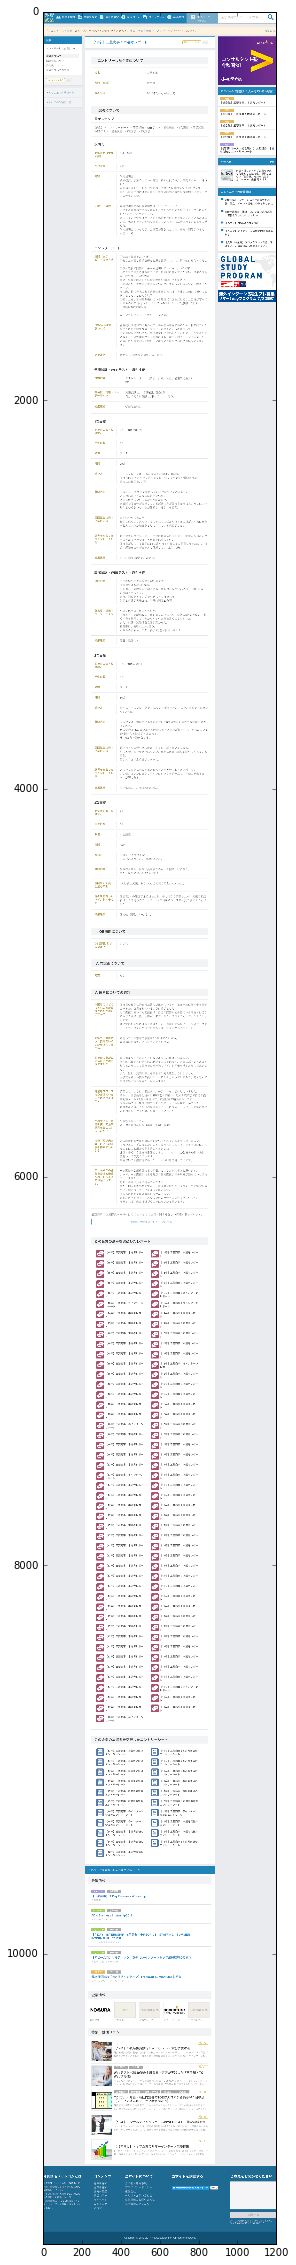

In [64]:
driver.get(es_url)
source = show_capture(driver)
es_page = BeautifulSoup(source, "lxml")

In [80]:
company_sls = {}
for sl_url in selection_reports:
    driver.implicitly_wait(1)
    driver.get(sl_url)
    source = driver.page_source.encode('utf-8')
    sl_page = BeautifulSoup(source, "lxml")
    try:
        importance = sl_page.find("td", class_="impression_importance").text
    except AttributeError:
        importance = ""
    try:
        advice = sl_page.find("td", class_="impression_advice").text
    except:
        advice = ""
    company_sls[sl_url] = {"importance": importance, "advice": advice}

In [82]:
len(company_sls)

94

In [86]:
import json
with open("mitshubishi_shouji.json", "w") as f:
    json.dump(company_sls, f)

## VORKERS

In [5]:
def show_capture(driver):
    data = driver.page_source.encode('utf-8')
    driver.save_screenshot("test.png")
    im = Image.open("test.png", "r")
    plt.figure(figsize=(12,40))
    plt.imshow(np.array(im))
    return data

In [8]:
# ログインページへのアクセスとログイン
driver = webdriver.PhantomJS(service_log_path=os.path.devnull)
driver.get("https://www.vorkers.com/login.php")
driver.implicitly_wait(1)
username_field = driver.find_element_by_name("_username")
password_field = driver.find_element_by_name("_password")
username_field.send_keys(vorkers["email"])
driver.implicitly_wait(1)
password_field.send_keys(vorkers["password"])
driver.implicitly_wait(1)
driver.find_element_by_css_selector("#log_in").click()

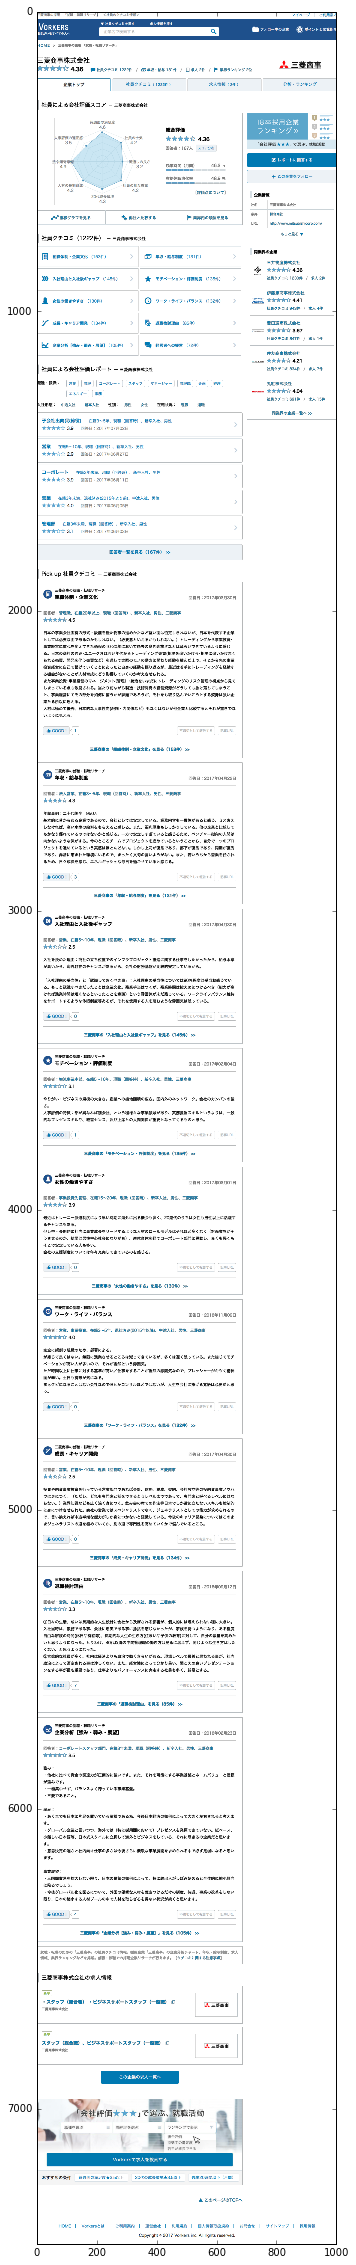

In [9]:
# 三菱商事のページへアクセス
driver.get("https://www.vorkers.com/company.php?m_id=a0910000000Frj0")
source = show_capture(driver)
company_page = BeautifulSoup(source, "lxml")

In [44]:
from pprint import pprint

In [46]:
# レーダーチャートのスコア
radar_elems = company_page.find("ul", class_="scoreList-8").find_all("li")
score_dic = {}
score_dic["radar"] = {}
radar_dic = score_dic["radar"]
for radar_elem in radar_elems:
        #key = radar_elem.get("class")[0].split("-")[-1]
        #description = radar_elem.find("dt").text
        #score = radar_elem.find("dd").text
        #radar_dic[key] = [description, score]
        key = radar_elem.find("dt").text
        score = radar_elem.find("dd").text
        radar_dic[key] = score
# 総合評価
#score_dic["average"] = ["総合評価", company_page.find("span", property="v:average").text]
score_dic["総合評価"] = company_page.find("span", property="v:average").text
# 残業時間(月間)と有給休暇消化率
zangyou, yuukyuu = company_page.find_all("dd", class_="d-ib t-r w-85")
score_dic["残業時間(月間)"] = zangyou.text
score_dic["有給休暇消化率"] = yuukyuu.text
pprint(score_dic)

{'radar': {'20代成長環境': '4.3',
           '人事評価の適正感': '3.5',
           '人材の長期育成': '4.2',
           '待遇面の満足度': '4.6',
           '法令順守意識': '4.9',
           '社員の士気': '4.2',
           '社員の相互尊重': '4.2',
           '風通しの良さ': '3.2'},
 '有給休暇消化率': '48.9 ％',
 '残業時間(月間)': '46.3 ｈ',
 '総合評価': '4.36'}


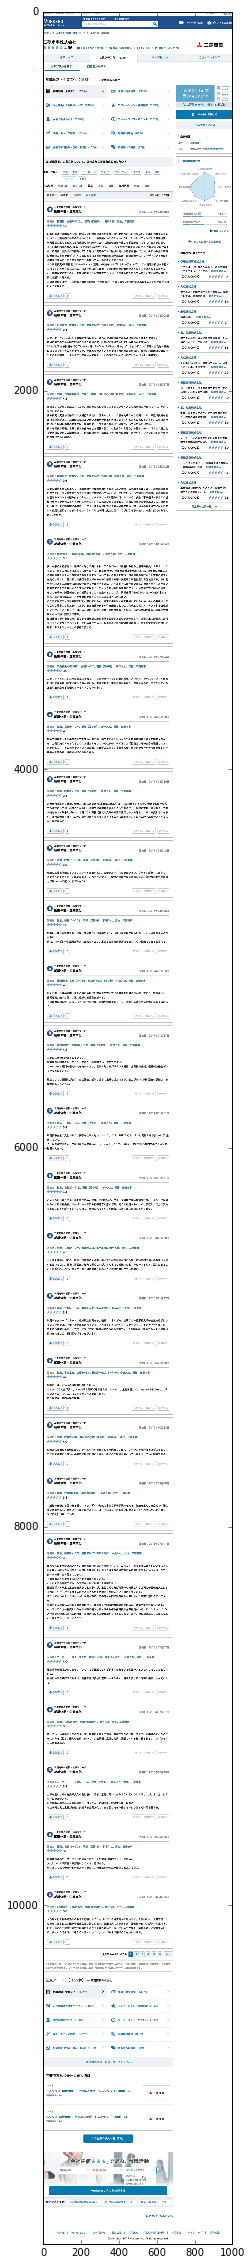

In [52]:
# 口コミページへアクセス
driver.get("https://www.vorkers.com/company_answer.php?m_id=a0910000000Frj0&q_no=1")
source = show_capture(driver)
kuchikomi_page = BeautifulSoup(source, "lxml")

In [ ]:
def 

In [62]:
kuchikomis = kuchikomi_page.find_all("dd", class_="article_answer")
kuchikomi_arr = [kuchikomi.text.strip("\n").strip() for kuchikomi in kuchikomis]
kuchikomi_arr

['日本の事業会社固有の形式・段階を経た物事の進めかたなど堅い面は否定しきれないが、日本を代表する企業としては必要な面であるのかもしれない。（必要悪といえるかもしれない。）トレーディングから事業投資･事業経営に重心を変えてきた過程の10-20年において過去の良き奔放さなどは薄らいできているように感じる。日本の商社の強み･ユニークさは若い年代からトレーディング売買(相場を追いかける･相場に追いかけまくられる売買、開発を伴う売買など）を通して実際のモノの動きに関わり経験を積んだ上で、そこから先の事業投資経営に自己で繋げていくことにあったと自身の経験を振り返るが、最近は若手にトレーディングを経験する機会がないことが人材育成にどう影響していくのか考えさせられる。\nまた事業投資･事業経営のマネージメント(管理）･統治をいまだにトレーディングのリスク管理の視点から見てしまっている点も散見される。当たり前ながら製造・技術開発の経営資源がどうしても抜け落ちてしまうこと、事業経営にてその部分を如何に補うかが課題であろうが、それをも取り込んでいこうとする姿勢は強い企業たる所以に思える。\n人材は極めて優秀、日本的な人事性向(派閥・力関係など）もなくはないが他企業と比較するとそれが重きでないように見える。',
 'コンプライアンスに対する意識が非常に高く、きれいごとがまかり通るため安心して仕事ができる。\n本当に実力のある人間が評価されるとは限らず、社内政治だけで泳いでいる輩もかなりいる。\n30台半ばから表街道を行くグループと外れたグループが分かれ始め、どの年次でどういう部署・出向先に異動になったで察することができるが、金銭的な待遇という面ではそれほど差は出ない。金銭的な報酬は役員にでもならない限り、出世したかしてないかではなく、どの国にどれくらい駐在したかが大きく影響する。',
 '会社としてかなり完成されており、経営陣の入れ替えも大きなサプライズなく周期的に行われていて、非常に安定している。\n昔の投資（資源や自動車での大博打と成功）は面白かったという話を先輩からよく聞いたが、最近は投資も控えめな空気があり、部署間の気の遣い合いと牽制の比重が大きくなっているように感じているが、このまま社内政治と根回し偏重のままでは、伊藤忠にトップを獲られる日も可能性としてはある気がする。\n日本

In [54]:
next_pages = kuchikomi_page.find_all("a", class_="paging_link-item")
next_pages[0].get("href")

'/company_answer.php?m_id=a0910000000Frj0&q_no=1&next_page=2'

In [63]:
if len(next_pages):
    for next_page in next_pages:
        driver.implicitly_wait(3)
        url = next_page.get("href")
        driver.get(url)
        source = driver.page_source.encode('utf-8')
        kuchikomi_page = BeautifulSoup(source, "lxml")
        kuchikomis = kuchikomi_page.find_all("dd", class_="article_answer")
        kuchikomi_arr += [kuchikomi.text.strip("\n").strip() for kuchikomi in kuchikomis]
kuchikomi_arr

['日本の事業会社固有の形式・段階を経た物事の進めかたなど堅い面は否定しきれないが、日本を代表する企業としては必要な面であるのかもしれない。（必要悪といえるかもしれない。）トレーディングから事業投資･事業経営に重心を変えてきた過程の10-20年において過去の良き奔放さなどは薄らいできているように感じる。日本の商社の強み･ユニークさは若い年代からトレーディング売買(相場を追いかける･相場に追いかけまくられる売買、開発を伴う売買など）を通して実際のモノの動きに関わり経験を積んだ上で、そこから先の事業投資経営に自己で繋げていくことにあったと自身の経験を振り返るが、最近は若手にトレーディングを経験する機会がないことが人材育成にどう影響していくのか考えさせられる。\nまた事業投資･事業経営のマネージメント(管理）･統治をいまだにトレーディングのリスク管理の視点から見てしまっている点も散見される。当たり前ながら製造・技術開発の経営資源がどうしても抜け落ちてしまうこと、事業経営にてその部分を如何に補うかが課題であろうが、それをも取り込んでいこうとする姿勢は強い企業たる所以に思える。\n人材は極めて優秀、日本的な人事性向(派閥・力関係など）もなくはないが他企業と比較するとそれが重きでないように見える。',
 'コンプライアンスに対する意識が非常に高く、きれいごとがまかり通るため安心して仕事ができる。\n本当に実力のある人間が評価されるとは限らず、社内政治だけで泳いでいる輩もかなりいる。\n30台半ばから表街道を行くグループと外れたグループが分かれ始め、どの年次でどういう部署・出向先に異動になったで察することができるが、金銭的な待遇という面ではそれほど差は出ない。金銭的な報酬は役員にでもならない限り、出世したかしてないかではなく、どの国にどれくらい駐在したかが大きく影響する。',
 '会社としてかなり完成されており、経営陣の入れ替えも大きなサプライズなく周期的に行われていて、非常に安定している。\n昔の投資（資源や自動車での大博打と成功）は面白かったという話を先輩からよく聞いたが、最近は投資も控えめな空気があり、部署間の気の遣い合いと牽制の比重が大きくなっているように感じているが、このまま社内政治と根回し偏重のままでは、伊藤忠にトップを獲られる日も可能性としてはある気がする。\n日本